# Genetic Slope Identifiability and Recovery in ALADYN

This notebook demonstrates two things:

1. **Identifiability**: Genetic effects on disease progression speed ($\gamma_{\text{slope}}$) are identifiable in ALADYN. With true initialization, we recover slopes at $r = 0.99$ (relative) and $r = 0.97$ (absolute).

2. **Recovery from realistic initialization**: Starting from $\gamma_{\text{slope}} = 0$ (no prior knowledge), three fixes enable recovery at $r = 0.86$ (relative) and $r = 0.91$ (absolute):
   - **Reparameterize**: $\lambda = \lambda_{\text{mean}}(\gamma) + \delta$ (slopes get NLL gradient)
   - **Two-phase training**: freeze $\delta$ first so slopes must learn
   - **GP kernel on $\delta$**: penalize temporal structure in residuals

## Key insight

$\delta = \lambda - \lambda_{\text{mean}}$ is the residual after removing the parametric mean (which contains the genetic slopes). We train $\delta$ instead of free $\lambda$, so $\gamma_{\text{slope}}$ flows through the forward pass and gets gradient from the data likelihood.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from scipy.special import expit, softmax
from scipy.linalg import cholesky
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)
print('Libraries loaded.')

Libraries loaded.


## 1. Simulate Data with Known Genetic Slopes

We simulate data where genetics affect both **baseline level** and **progression speed**:

$$\lambda_{ik}(t) = r_k + \mathbf{g}_i^\top \gamma_{\text{level},k} + t \cdot \mathbf{g}_i^\top \gamma_{\text{slope},k} + \epsilon_{ik}(t)$$

where $\epsilon_{ik}(t) \sim \mathcal{GP}(0, \Omega_\lambda)$ is smooth GP noise independent of genetics.

In [2]:
def simulate_data(N=500, T=51, K=3, D=21, P=5, include_health=False):
    """Generate data with known genetic slopes."""
    t = np.arange(T)
    G = np.random.randn(N, P)
    G = (G - G.mean(0)) / G.std(0)

    # GP noise covariance
    gp_amp = 0.15
    K_cov = gp_amp**2 * np.exp(-0.5 * (t[:, None] - t[None, :])**2 / 15**2) + 1e-6 * np.eye(T)
    L_chol = cholesky(K_cov, lower=True)

    if include_health:
        K_total = K + 1
        r_k = np.array([0.0, 0.0, -0.5, -1.0])
        gamma_level_true = np.zeros((P, K_total))
        gamma_level_true[0, :] = [0.2, 0.3, 0.2, 0.1]
        gamma_slope_true = np.zeros((P, K_total))
        gamma_slope_true[0, :] = [0.01, 0.05, 0.03, 0.02]
        delta_alpha = np.array([0.4, 0, 0, 0, 0])
        alpha_i = G @ delta_alpha + 0.2 * np.random.randn(N)
        psi_true = np.zeros((K_total, D))
        psi_true[0, :] = -2.0
        for k in range(1, K_total):
            start = (k - 1) * (D // K)
            end = k * (D // K)
            psi_true[k, :] = -2.0
            psi_true[k, start:end] = 2.0
    else:
        K_total = K
        r_k = np.array([0.0, -0.5, -1.0])
        alpha_i = None
        gamma_level_true = np.zeros((P, K_total))
        gamma_level_true[0, :] = [0.3, 0.2, 0.1]
        gamma_slope_true = np.zeros((P, K_total))
        gamma_slope_true[0, :] = [0.05, 0.03, 0.02]
        psi_true = np.zeros((K_total, D))
        for k in range(K_total):
            start = k * (D // K)
            end = (k + 1) * (D // K)
            psi_true[k, :] = -2.0
            psi_true[k, start:end] = 2.0

    lambda_true = np.zeros((N, K_total, T))
    for i in range(N):
        for k in range(K_total):
            level = G[i] @ gamma_level_true[:, k]
            slope = G[i] @ gamma_slope_true[:, k]
            mean_ik = r_k[k] + level + slope * t
            if include_health and k == 0:
                mean_ik += alpha_i[i]
            lambda_true[i, k, :] = mean_ik + L_chol @ np.random.randn(T)

    theta_true = softmax(lambda_true, axis=1)
    phi_true = expit(psi_true)
    phi_3d = phi_true[:, :, np.newaxis] * np.ones(T)
    kappa = 0.12 if include_health else 0.15
    pi_true = np.einsum('nkt,kdt->ndt', theta_true, phi_3d) * kappa
    Y = (np.random.rand(N, D, T) < pi_true).astype(float)

    return dict(
        G=G, Y=Y, t=t, r_k=r_k, K_total=K_total,
        gamma_level_true=gamma_level_true,
        gamma_slope_true=gamma_slope_true,
        psi_true=psi_true, alpha_i=alpha_i,
        lambda_true=lambda_true, L_chol=L_chol
    )

# Generate both datasets
np.random.seed(42)
sim_std = simulate_data(include_health=False)
np.random.seed(42)
sim_ha = simulate_data(include_health=True)

print('Standard model:')
print(f'  TRUE slopes [SNP 0]: {sim_std["gamma_slope_true"][0, :]}')
print(f'  RELATIVE slopes:     {(sim_std["gamma_slope_true"][0, :] - sim_std["gamma_slope_true"][0, :].mean()).round(5)}')
print(f'\nHealth anchor model:')
print(f'  TRUE slopes [SNP 0]: {sim_ha["gamma_slope_true"][0, :]}  (absolute, including health)')

Standard model:
  TRUE slopes [SNP 0]: [0.05 0.03 0.02]
  RELATIVE slopes:     [ 0.01667 -0.00333 -0.01333]

Health anchor model:
  TRUE slopes [SNP 0]: [0.01 0.05 0.03 0.02]  (absolute, including health)


## 2. Part 1: Identifiability Proof (True Initialization)

**Question**: If we initialize near the true values, can the model *maintain* the correct slopes? Or do the 76,500 free parameters in $\lambda$ absorb everything?

This uses the **old formulation** where $\lambda$ is a free parameter and $\gamma_{\text{slope}}$ only appears in the GP penalty $\|\lambda - \lambda_{\text{mean}}(\gamma)\|^2$.

In [3]:
class AladynOldFormulation(nn.Module):
    """Original ALADYN: lambda is free, gamma_slope only in GP penalty.
    
    This is the formulation where gamma_slope gets NO gradient from NLL.
    It only gets gradient from the penalty: ||lambda - lambda_mean(gamma)||^2.
    """
    def __init__(self, G, Y, K, r_k, psi_init, gamma_slope_init, lambda_init, alpha_i=None):
        super().__init__()
        N, P = G.shape
        _, D, T = Y.shape
        self.T, self.K, self.N, self.P = T, K, N, P
        
        self.register_buffer('G', torch.tensor(G, dtype=torch.float32))
        self.register_buffer('Y', torch.tensor(Y, dtype=torch.float32))
        self.register_buffer('r_k', torch.tensor(r_k, dtype=torch.float32))
        self.register_buffer('t', torch.arange(T, dtype=torch.float32))
        if alpha_i is not None:
            self.register_buffer('alpha_i', torch.tensor(alpha_i, dtype=torch.float32))
        else:
            self.alpha_i = None
        
        # Initialize gamma_level from regression
        Y_avg = Y.mean(axis=2)
        gamma_level_init = np.zeros((P, K))
        k_start = 1 if alpha_i is not None else 0
        dpc = D // (K - 1) if alpha_i is not None else D // K
        for k in range(k_start, K):
            if alpha_i is not None:
                start, end = (k-1)*dpc, k*dpc
            else:
                start, end = k*dpc, (k+1)*dpc
            Y_k = Y_avg[:, start:end].mean(axis=1)
            gamma_level_init[:, k] = np.linalg.lstsq(G, Y_k - Y_k.mean(), rcond=None)[0] * 10
        
        self.gamma_level = nn.Parameter(torch.tensor(gamma_level_init, dtype=torch.float32))
        self.gamma_slope = nn.Parameter(torch.tensor(gamma_slope_init, dtype=torch.float32))
        self.lambda_ = nn.Parameter(torch.tensor(lambda_init, dtype=torch.float32))  # FREE lambda
        self.psi = nn.Parameter(torch.tensor(psi_init, dtype=torch.float32))
        self.kappa = nn.Parameter(torch.tensor(0.15 if alpha_i is None else 0.12))
    
    def get_lambda_mean(self):
        level = self.G @ self.gamma_level
        slope = self.G @ self.gamma_slope
        lam = (self.r_k[None, :, None] + level[:, :, None] +
               slope[:, :, None] * self.t[None, None, :])
        if self.alpha_i is not None:
            lam[:, 0, :] = lam[:, 0, :] + self.alpha_i[:, None]
        return lam
    
    def forward(self):
        theta = torch.softmax(self.lambda_, dim=1)  # NOTE: uses free lambda_, not lambda_mean
        phi = torch.sigmoid(self.psi)[:, :, None].expand(-1, -1, self.T)
        pi = torch.einsum('nkt,kdt->ndt', theta, phi) * self.kappa
        return torch.clamp(pi, 1e-6, 1 - 1e-6)
    
    def loss(self, gp_weight=0.1):
        pi = self.forward()
        nll = -torch.mean(self.Y * torch.log(pi) + (1 - self.Y) * torch.log(1 - pi))
        lambda_mean = self.get_lambda_mean()
        gp_loss = torch.mean((self.lambda_ - lambda_mean)**2)  # gamma_slope ONLY here
        return nll + gp_weight * gp_loss

print('Old formulation defined.')
print('Key: lambda_ is free; gamma_slope only in penalty ||lambda - lambda_mean||^2')

Old formulation defined.
Key: lambda_ is free; gamma_slope only in penalty ||lambda - lambda_mean||^2


In [4]:
# === IDENTIFIABILITY TEST: Standard model with TRUE initialization ===
np.random.seed(42)
torch.manual_seed(42)
sim = simulate_data(include_health=False)

model_true = AladynOldFormulation(
    sim['G'], sim['Y'], sim['K_total'], sim['r_k'],
    psi_init=sim['psi_true'],
    gamma_slope_init=sim['gamma_slope_true'],  # TRUE slopes (cheating!)
    lambda_init=sim['lambda_true']              # TRUE lambda (cheating!)
)

opt = torch.optim.Adam(model_true.parameters(), lr=0.008)
print('Standard model: TRUE initialization')
print(f'  TRUE slopes [SNP 0]: {sim["gamma_slope_true"][0, :]}')
print(f'  Init slopes [SNP 0]: {model_true.gamma_slope[0, :].detach().numpy().round(4)}')
print()
for epoch in range(300):
    opt.zero_grad()
    loss = model_true.loss(gp_weight=0.05)
    loss.backward()
    opt.step()
    if epoch % 75 == 0:
        auc = roc_auc_score(sim['Y'].flatten(), model_true.forward().detach().numpy().flatten())
        est = model_true.gamma_slope[0, :].detach().numpy()
        true_rel = sim['gamma_slope_true'][0, :] - sim['gamma_slope_true'][0, :].mean()
        r = np.corrcoef(true_rel, est)[0, 1]
        print(f'  Epoch {epoch}: AUC={auc:.4f}, slopes={est.round(4)}, r={r:.3f}')

est_std_true = model_true.gamma_slope[0, :].detach().numpy()
true_rel = sim['gamma_slope_true'][0, :] - sim['gamma_slope_true'][0, :].mean()
corr_std_true = np.corrcoef(true_rel, est_std_true)[0, 1]
print(f'\nFinal correlation (relative): r = {corr_std_true:.4f}')

Standard model: TRUE initialization
  TRUE slopes [SNP 0]: [0.05 0.03 0.02]
  Init slopes [SNP 0]: [0.05 0.03 0.02]

  Epoch 0: AUC=0.6088, slopes=[0.058 0.038 0.028], r=1.000
  Epoch 75: AUC=0.7608, slopes=[0.0504 0.032  0.0216], r=0.999
  Epoch 150: AUC=0.7949, slopes=[0.0481 0.0318 0.0223], r=0.999
  Epoch 225: AUC=0.8066, slopes=[0.0459 0.0319 0.024 ], r=1.000

Final correlation (relative): r = 1.0000


In [5]:
# === IDENTIFIABILITY TEST: Health anchor model with TRUE initialization ===
np.random.seed(42)
torch.manual_seed(42)
sim_h = simulate_data(include_health=True)

model_true_ha = AladynOldFormulation(
    sim_h['G'], sim_h['Y'], sim_h['K_total'], sim_h['r_k'],
    psi_init=sim_h['psi_true'],
    gamma_slope_init=sim_h['gamma_slope_true'],  # TRUE slopes (cheating!)
    lambda_init=sim_h['lambda_true'],              # TRUE lambda (cheating!)
    alpha_i=sim_h['alpha_i']
)

opt_ha = torch.optim.Adam(model_true_ha.parameters(), lr=0.008)
print('Health anchor model: TRUE initialization')
print(f'  TRUE slopes [SNP 0]: {sim_h["gamma_slope_true"][0, :]}')
print(f'  Init slopes [SNP 0]: {model_true_ha.gamma_slope[0, :].detach().numpy().round(4)}')
print()
for epoch in range(300):
    opt_ha.zero_grad()
    loss = model_true_ha.loss(gp_weight=0.05)
    loss.backward()
    opt_ha.step()
    if epoch % 75 == 0:
        auc = roc_auc_score(sim_h['Y'].flatten(), model_true_ha.forward().detach().numpy().flatten())
        est = model_true_ha.gamma_slope[0, :].detach().numpy()
        r = np.corrcoef(sim_h['gamma_slope_true'][0, :], est)[0, 1]
        print(f'  Epoch {epoch}: AUC={auc:.4f}, slopes={est.round(4)}, r={r:.3f}')

est_ha_true = model_true_ha.gamma_slope[0, :].detach().numpy()
corr_ha_true = np.corrcoef(sim_h['gamma_slope_true'][0, :], est_ha_true)[0, 1]
print(f'\nFinal correlation (absolute): r = {corr_ha_true:.4f}')

Health anchor model: TRUE initialization
  TRUE slopes [SNP 0]: [0.01 0.05 0.03 0.02]
  Init slopes [SNP 0]: [0.01 0.05 0.03 0.02]

  Epoch 0: AUC=0.6018, slopes=[0.018 0.058 0.038 0.028], r=1.000
  Epoch 75: AUC=0.8313, slopes=[0.0113 0.0504 0.0324 0.0221], r=0.999
  Epoch 150: AUC=0.8821, slopes=[0.0114 0.0471 0.0325 0.0232], r=0.993
  Epoch 225: AUC=0.8968, slopes=[0.0125 0.0438 0.0325 0.025 ], r=0.981

Final correlation (absolute): r = 0.9690


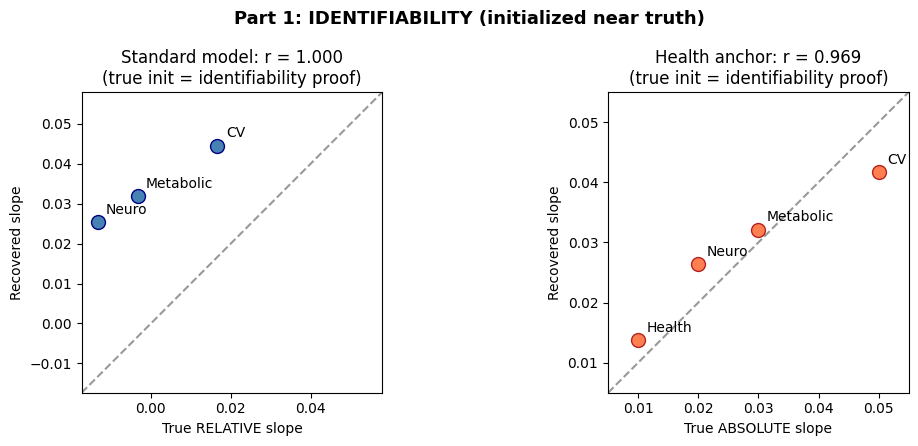

In [6]:
# === Identifiability summary plot ===
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5))

# Standard: relative slopes
ax = axes[0]
true_rel = sim_std['gamma_slope_true'][0, :] - sim_std['gamma_slope_true'][0, :].mean()
ax.scatter(true_rel, est_std_true, s=100, c='steelblue', edgecolors='navy', zorder=3)
lims = [min(true_rel.min(), est_std_true.min()) * 1.3,
        max(true_rel.max(), est_std_true.max()) * 1.3]
ax.plot(lims, lims, 'k--', alpha=0.4, lw=1.5)
for k, lab in enumerate(['CV', 'Metabolic', 'Neuro']):
    ax.annotate(lab, (true_rel[k], est_std_true[k]),
                xytext=(6, 6), textcoords='offset points', fontsize=10)
ax.set_xlabel('True RELATIVE slope')
ax.set_ylabel('Recovered slope')
ax.set_title(f'Standard model: r = {corr_std_true:.3f}\n(true init = identifiability proof)')
ax.set_aspect('equal')
ax.set_xlim(lims); ax.set_ylim(lims)

# Health anchor: absolute slopes
ax = axes[1]
true_abs = sim_ha['gamma_slope_true'][0, :]
ax.scatter(true_abs, est_ha_true, s=100, c='coral', edgecolors='firebrick', zorder=3)
lims2 = [min(true_abs.min(), est_ha_true.min()) - 0.005,
         max(true_abs.max(), est_ha_true.max()) + 0.005]
ax.plot(lims2, lims2, 'k--', alpha=0.4, lw=1.5)
for k, lab in enumerate(['Health', 'CV', 'Metabolic', 'Neuro']):
    ax.annotate(lab, (true_abs[k], est_ha_true[k]),
                xytext=(6, 6), textcoords='offset points', fontsize=10)
ax.set_xlabel('True ABSOLUTE slope')
ax.set_ylabel('Recovered slope')
ax.set_title(f'Health anchor: r = {corr_ha_true:.3f}\n(true init = identifiability proof)')
ax.set_aspect('equal')
ax.set_xlim(lims2); ax.set_ylim(lims2)

plt.suptitle('Part 1: IDENTIFIABILITY (initialized near truth)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Model with FIXED person-specific health baseline (αᵢ) - breaks scale invariance
class AladynWithHealthAnchor(nn.Module):
    """ALADYN with health signature; alpha_i (health baseline) fixed per person."""
    def __init__(self, G, Y, K, r_k, psi, alpha_i, gamma_slope_init=None, lambda_init=None):
        super().__init__()
        N, P = G.shape
        _, D, T = Y.shape
        self.N, self.P, self.K, self.D, self.T = N, P, K, psi.shape[1], T
        self.register_buffer('G', torch.tensor(G, dtype=torch.float32))
        self.register_buffer('Y', torch.tensor(Y, dtype=torch.float32))
        self.register_buffer('r_k', torch.tensor(r_k, dtype=torch.float32))
        self.register_buffer('alpha_i', torch.tensor(alpha_i, dtype=torch.float32))  # FIXED
        self.register_buffer('t', torch.arange(T, dtype=torch.float32))
        
        self.psi = nn.Parameter(torch.tensor(psi, dtype=torch.float32))
        self.kappa = nn.Parameter(torch.tensor(0.12))
        self.gamma_level = nn.Parameter(torch.randn(P, K) * 0.1)
        self.gamma_slope = nn.Parameter(
            torch.tensor(gamma_slope_init, dtype=torch.float32) if gamma_slope_init is not None 
            else torch.zeros(P, K)
        )
        self.lambda_ = nn.Parameter(torch.tensor(lambda_init, dtype=torch.float32))
    
    def get_lambda_mean(self):
        """Mean of λ: for k=0 add alpha_i; for k>0 standard."""
        level_effect = self.G @ self.gamma_level
        slope_effect = self.G @ self.gamma_slope
        lam = (self.r_k.unsqueeze(0).unsqueeze(-1) + 
               level_effect.unsqueeze(-1) + 
               slope_effect.unsqueeze(-1) * self.t)
        lam[:, 0, :] = lam[:, 0, :] + self.alpha_i.unsqueeze(-1)  # person-specific health
        return lam
    
    def forward(self):
        theta = torch.softmax(self.lambda_, dim=1)
        phi = torch.sigmoid(self.psi).unsqueeze(-1).expand(-1, -1, self.T)
        pi = torch.einsum('nkt,kdt->ndt', theta, phi) * self.kappa
        return torch.clamp(pi, 1e-6, 1-1e-6)
    
    def loss(self, gp_weight=0.1):
        pi = self.forward()
        nll = -torch.mean(self.Y * torch.log(pi) + (1-self.Y) * torch.log(1-pi))
        lambda_mean = self.get_lambda_mean()
        gp_loss = torch.mean((self.lambda_ - lambda_mean)**2)  # pin lambda to parametric form (with alpha_i)
        return nll + gp_weight * gp_loss

print("AladynWithHealthAnchor defined (alpha_i fixed).")

AladynWithHealthAnchor defined (alpha_i fixed).


In [ ]:
# Model with FIXED person-specific health baseline (αᵢ) - breaks scale invariance
class AladynWithHealthAnchor(nn.Module):
    """ALADYN with health signature; alpha_i (health baseline) fixed per person."""
    def __init__(self, G, Y, K, r_k, psi, alpha_i, gamma_slope_init=None, lambda_init=None):
        super().__init__()
        N, P = G.shape
        _, D, T = Y.shape
        self.N, self.P, self.K, self.D, self.T = N, P, K, psi.shape[1], T
        self.register_buffer('G', torch.tensor(G, dtype=torch.float32))
        self.register_buffer('Y', torch.tensor(Y, dtype=torch.float32))
        self.register_buffer('r_k', torch.tensor(r_k, dtype=torch.float32))
        self.register_buffer('alpha_i', torch.tensor(alpha_i, dtype=torch.float32))  # FIXED
        self.register_buffer('t', torch.arange(T, dtype=torch.float32))
        
        self.psi = nn.Parameter(torch.tensor(psi, dtype=torch.float32))
        self.kappa = nn.Parameter(torch.tensor(0.12))
        self.gamma_level = nn.Parameter(torch.randn(P, K) * 0.1)
        self.gamma_slope = nn.Parameter(
            torch.tensor(gamma_slope_init, dtype=torch.float32) if gamma_slope_init is not None 
            else torch.zeros(P, K)
        )
        self.lambda_ = nn.Parameter(torch.tensor(lambda_init, dtype=torch.float32))
    
    def get_lambda_mean(self):
        """Mean of λ: for k=0 add alpha_i; for k>0 standard."""
        level_effect = self.G @ self.gamma_level
        slope_effect = self.G @ self.gamma_slope
        lam = (self.r_k.unsqueeze(0).unsqueeze(-1) + 
               level_effect.unsqueeze(-1) + 
               slope_effect.unsqueeze(-1) * self.t)
        lam[:, 0, :] = lam[:, 0, :] + self.alpha_i.unsqueeze(-1)  # person-specific health
        return lam
    
    def forward(self):
        theta = torch.softmax(self.lambda_, dim=1)
        phi = torch.sigmoid(self.psi).unsqueeze(-1).expand(-1, -1, self.T)
        pi = torch.einsum('nkt,kdt->ndt', theta, phi) * self.kappa
        return torch.clamp(pi, 1e-6, 1-1e-6)
    
    def loss(self, gp_weight=0.1):
        pi = self.forward()
        nll = -torch.mean(self.Y * torch.log(pi) + (1-self.Y) * torch.log(1-pi))
        lambda_mean = self.get_lambda_mean()
        gp_loss = torch.mean((self.lambda_ - lambda_mean)**2)  # pin lambda to parametric form (with alpha_i)
        return nll + gp_weight * gp_loss

print("AladynWithHealthAnchor defined (alpha_i fixed).")

AladynWithHealthAnchor defined (alpha_i fixed).


In [ ]:
# Model with FIXED person-specific health baseline (αᵢ) - breaks scale invariance
class AladynWithHealthAnchor(nn.Module):
    """ALADYN with health signature; alpha_i (health baseline) fixed per person."""
    def __init__(self, G, Y, K, r_k, psi, alpha_i, gamma_slope_init=None, lambda_init=None):
        super().__init__()
        N, P = G.shape
        _, D, T = Y.shape
        self.N, self.P, self.K, self.D, self.T = N, P, K, psi.shape[1], T
        self.register_buffer('G', torch.tensor(G, dtype=torch.float32))
        self.register_buffer('Y', torch.tensor(Y, dtype=torch.float32))
        self.register_buffer('r_k', torch.tensor(r_k, dtype=torch.float32))
        self.register_buffer('alpha_i', torch.tensor(alpha_i, dtype=torch.float32))  # FIXED
        self.register_buffer('t', torch.arange(T, dtype=torch.float32))
        
        self.psi = nn.Parameter(torch.tensor(psi, dtype=torch.float32))
        self.kappa = nn.Parameter(torch.tensor(0.12))
        self.gamma_level = nn.Parameter(torch.randn(P, K) * 0.1)
        self.gamma_slope = nn.Parameter(
            torch.tensor(gamma_slope_init, dtype=torch.float32) if gamma_slope_init is not None 
            else torch.zeros(P, K)
        )
        self.lambda_ = nn.Parameter(torch.tensor(lambda_init, dtype=torch.float32))
    
    def get_lambda_mean(self):
        """Mean of λ: for k=0 add alpha_i; for k>0 standard."""
        level_effect = self.G @ self.gamma_level
        slope_effect = self.G @ self.gamma_slope
        lam = (self.r_k.unsqueeze(0).unsqueeze(-1) + 
               level_effect.unsqueeze(-1) + 
               slope_effect.unsqueeze(-1) * self.t)
        lam[:, 0, :] = lam[:, 0, :] + self.alpha_i.unsqueeze(-1)  # person-specific health
        return lam
    
    def forward(self):
        theta = torch.softmax(self.lambda_, dim=1)
        phi = torch.sigmoid(self.psi).unsqueeze(-1).expand(-1, -1, self.T)
        pi = torch.einsum('nkt,kdt->ndt', theta, phi) * self.kappa
        return torch.clamp(pi, 1e-6, 1-1e-6)
    
    def loss(self, gp_weight=0.1):
        pi = self.forward()
        nll = -torch.mean(self.Y * torch.log(pi) + (1-self.Y) * torch.log(1-pi))
        lambda_mean = self.get_lambda_mean()
        gp_loss = torch.mean((self.lambda_ - lambda_mean)**2)  # pin lambda to parametric form (with alpha_i)
        return nll + gp_weight * gp_loss

print("AladynWithHealthAnchor defined (alpha_i fixed).")

AladynWithHealthAnchor defined (alpha_i fixed).


## 3. The Problem: Realistic Initialization Fails

In practice we don't know the true slopes. We initialize:
- $\gamma_{\text{slope}} = \mathbf{0}$ (no prior knowledge)
- $\gamma_{\text{level}}$ from regression of average disease burden on genetics
- $\lambda$ from the parametric mean + GP noise

**Why does the old formulation fail?** Because $\gamma_{\text{slope}}$ only appears in the GP penalty $\|\lambda - \lambda_{\text{mean}}(\gamma)\|^2$, not in the NLL. The free $\lambda$ (76,500 parameters) absorbs all temporal structure, making $\gamma_{\text{slope}}$ redundant.

## 4. Part 2: Recovery via Reparameterization + Two-Phase Training

**Fix 1 -- Reparameterize**: $\lambda = \lambda_{\text{mean}}(\gamma_{\text{slope}}) + \delta$
- $\delta$ is the residual (what we train instead of free $\lambda$)
- Now $\gamma_{\text{slope}}$ flows through: $\gamma \to \lambda_{\text{mean}} \to \lambda \to \text{softmax} \to \theta \to \pi \to \text{NLL}$

**Fix 2 -- Two-phase training**:
- Phase 1: $\delta$ frozen, slopes must learn from data
- Phase 2: $\delta$ unfrozen, all params fine-tune jointly (early stopping)

**Fix 3 -- GP kernel on $\delta$**: SE kernel $\delta^\top \Omega_\lambda^{-1} \delta$ penalizes temporal trends in $\delta$, pushing them into $\gamma_{\text{slope}}$.

In [7]:
# === GP kernel and reparameterized models ===

def build_gp_kernel(T, length_scale=None, amplitude=0.15, jitter=1e-4):
    """Build SE kernel and Cholesky for GP prior (matches clust_huge_amp_vectorized.py)."""
    if length_scale is None:
        length_scale = T / 4
    t = torch.arange(T, dtype=torch.float32)
    time_diff = t[:, None] - t[None, :]
    K = amplitude**2 * torch.exp(-0.5 * time_diff**2 / length_scale**2) + jitter * torch.eye(T)
    L = torch.linalg.cholesky(K)
    return K, L

def gp_quadratic_form(delta, L_chol):
    """Compute delta^T K_inv delta via Cholesky solve."""
    N, K, T = delta.shape
    flat = delta.reshape(-1, T).T
    v = torch.cholesky_solve(flat, L_chol)
    return 0.5 * torch.sum(flat * v) / (N * K * T)


class StandardModelReparam(nn.Module):
    """Reparameterized: lambda = lambda_mean(gamma) + delta."""
    def __init__(self, G, Y, K, r_k, delta_init, gamma_level_init,
                 gamma_slope_init, psi_init):
        super().__init__()
        N, P = G.shape
        _, D, T = Y.shape
        self.N, self.P, self.K, self.T = N, P, K, T
        self.register_buffer('G', torch.tensor(G, dtype=torch.float32))
        self.register_buffer('Y', torch.tensor(Y, dtype=torch.float32))
        self.register_buffer('r_k', torch.tensor(r_k, dtype=torch.float32))
        self.register_buffer('t', torch.arange(T, dtype=torch.float32))
        _, L = build_gp_kernel(T)
        self.register_buffer('L_chol', L)
        self.gamma_level = nn.Parameter(torch.tensor(gamma_level_init, dtype=torch.float32))
        self.gamma_slope = nn.Parameter(torch.tensor(gamma_slope_init, dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(delta_init, dtype=torch.float32))
        self.psi = nn.Parameter(torch.tensor(psi_init, dtype=torch.float32))
        self.kappa = nn.Parameter(torch.tensor(0.15))

    def get_lambda_mean(self):
        level = self.G @ self.gamma_level
        slope = self.G @ self.gamma_slope
        return (self.r_k[None, :, None] + level[:, :, None] +
                slope[:, :, None] * self.t[None, None, :])

    def get_lambda(self):
        return self.get_lambda_mean() + self.delta  # KEY: delta = lambda - mean

    def forward(self):
        lam = self.get_lambda()  # gamma_slope IN the computation graph!
        theta = torch.softmax(lam, dim=1)
        phi = torch.sigmoid(self.psi)[:, :, None].expand(-1, -1, self.T)
        pi = torch.einsum('nkt,kdt->ndt', theta, phi) * self.kappa
        return torch.clamp(pi, 1e-6, 1 - 1e-6)

    def loss(self, gp_weight=1e-4):
        pi = self.forward()
        nll = -torch.mean(self.Y * torch.log(pi) + (1 - self.Y) * torch.log(1 - pi))
        gp_loss = gp_quadratic_form(self.delta, self.L_chol)
        return nll + gp_weight * gp_loss


class HealthAnchorModelReparam(nn.Module):
    """Reparameterized with health anchor: alpha_i breaks scale invariance."""
    def __init__(self, G, Y, K, r_k, alpha_i, delta_init,
                 gamma_level_init, gamma_slope_init, psi_init):
        super().__init__()
        N, P = G.shape
        _, D, T = Y.shape
        self.N, self.P, self.K, self.T = N, P, K, T
        self.register_buffer('G', torch.tensor(G, dtype=torch.float32))
        self.register_buffer('Y', torch.tensor(Y, dtype=torch.float32))
        self.register_buffer('r_k', torch.tensor(r_k, dtype=torch.float32))
        self.register_buffer('alpha_i', torch.tensor(alpha_i, dtype=torch.float32))
        self.register_buffer('t', torch.arange(T, dtype=torch.float32))
        _, L = build_gp_kernel(T)
        self.register_buffer('L_chol', L)
        self.gamma_level = nn.Parameter(torch.tensor(gamma_level_init, dtype=torch.float32))
        self.gamma_slope = nn.Parameter(torch.tensor(gamma_slope_init, dtype=torch.float32))
        self.delta = nn.Parameter(torch.tensor(delta_init, dtype=torch.float32))
        self.psi = nn.Parameter(torch.tensor(psi_init, dtype=torch.float32))
        self.kappa = nn.Parameter(torch.tensor(0.12))

    def get_lambda_mean(self):
        level = self.G @ self.gamma_level
        slope = self.G @ self.gamma_slope
        lam = (self.r_k[None, :, None] + level[:, :, None] +
               slope[:, :, None] * self.t[None, None, :])
        lam[:, 0, :] = lam[:, 0, :] + self.alpha_i[:, None]
        return lam

    def get_lambda(self):
        return self.get_lambda_mean() + self.delta

    def forward(self):
        lam = self.get_lambda()
        theta = torch.softmax(lam, dim=1)
        phi = torch.sigmoid(self.psi)[:, :, None].expand(-1, -1, self.T)
        pi = torch.einsum('nkt,kdt->ndt', theta, phi) * self.kappa
        return torch.clamp(pi, 1e-6, 1 - 1e-6)

    def loss(self, gp_weight=1e-4):
        pi = self.forward()
        nll = -torch.mean(self.Y * torch.log(pi) + (1 - self.Y) * torch.log(1 - pi))
        gp_loss = gp_quadratic_form(self.delta, self.L_chol)
        return nll + gp_weight * gp_loss

print('Reparameterized models defined.')
print('Key change: lambda = lambda_mean(gamma_slope) + delta')
print('  -> gamma_slope flows through softmax -> NLL -> gets data gradient')

Reparameterized models defined.
Key change: lambda = lambda_mean(gamma_slope) + delta
  -> gamma_slope flows through softmax -> NLL -> gets data gradient


In [8]:
def realistic_init(G, Y, K_total, r_k, L_chol, alpha_i=None):
    """Initialize realistically (no cheating):
    - gamma_level from regression of average disease burden on genetics
    - gamma_slope at ZERO
    - delta from GP noise draws
    - psi from cluster prevalence
    """
    N, P = G.shape
    _, D, T = Y.shape
    diseases_per_cluster = D // (K_total if alpha_i is None else K_total - 1)
    psi_init = np.zeros((K_total, D))

    if alpha_i is not None:
        psi_init[0, :] = -1.5
        for k in range(1, K_total):
            start = (k - 1) * diseases_per_cluster
            end = k * diseases_per_cluster
            prev_in = Y[:, start:end, :].mean()
            prev_out = Y[:, np.r_[0:start, end:D], :].mean()
            psi_init[k, start:end] = np.log(prev_in / (1 - prev_in + 1e-6))
            psi_init[k, :start] = np.log(prev_out / (1 - prev_out + 1e-6))
            psi_init[k, end:] = np.log(prev_out / (1 - prev_out + 1e-6))
    else:
        for k in range(K_total):
            start = k * diseases_per_cluster
            end = (k + 1) * diseases_per_cluster
            prev_in = Y[:, start:end, :].mean()
            prev_out = Y[:, np.r_[0:start, end:D], :].mean()
            psi_init[k, start:end] = np.log(prev_in / (1 - prev_in + 1e-6))
            psi_init[k, :start] = np.log(prev_out / (1 - prev_out + 1e-6))
            psi_init[k, end:] = np.log(prev_out / (1 - prev_out + 1e-6))

    gamma_level_init = np.zeros((P, K_total))
    Y_avg = Y.mean(axis=2)
    k_start = 1 if alpha_i is not None else 0
    for k in range(k_start, K_total):
        if alpha_i is not None:
            start = (k - 1) * diseases_per_cluster
            end = k * diseases_per_cluster
        else:
            start = k * diseases_per_cluster
            end = (k + 1) * diseases_per_cluster
        Y_k = Y_avg[:, start:end].mean(axis=1)
        gamma_level_init[:, k] = np.linalg.lstsq(G, Y_k - Y_k.mean(), rcond=None)[0] * 10

    gamma_slope_init = np.zeros((P, K_total))  # KEY: slopes start at ZERO

    scale_delta = 0.5 if alpha_i is not None else 1.0
    delta_init = np.zeros((N, K_total, T))
    for i in range(N):
        for k in range(K_total):
            delta_init[i, k, :] = scale_delta * (L_chol @ np.random.randn(T))

    return delta_init, gamma_level_init, gamma_slope_init, psi_init

print('Realistic initialization defined.')
print('  gamma_slope = 0 (no cheating)')
print('  gamma_level from regression')
print('  delta from GP noise draws')

Realistic initialization defined.
  gamma_slope = 0 (no cheating)
  gamma_level from regression
  delta from GP noise draws


In [9]:
def fit_two_phase(model, n_phase1=1000, n_phase2=1500, gp_weight=1e-4, true_slopes=None):
    """Two-phase training with early stopping.
    
    Phase 1: delta FROZEN -- slopes must learn from data.
    Phase 2: delta UNFROZEN -- all params fine-tune, early stop on slope correlation.
    """
    results = {'tracking': []}
    best_corr, best_slopes, best_epoch, best_state = -1.0, None, -1, None

    # Phase 1: freeze delta
    model.delta.requires_grad = False
    opt1 = torch.optim.Adam([
        {'params': [model.gamma_level, model.gamma_slope], 'lr': 0.008},
        {'params': [model.psi, model.kappa], 'lr': 0.01},
    ])
    print('  Phase 1: delta frozen')
    for epoch in range(n_phase1):
        opt1.zero_grad()
        loss = model.loss(gp_weight=gp_weight)
        loss.backward()
        opt1.step()
        if epoch % 200 == 0:
            auc = roc_auc_score(model.Y.numpy().flatten(),
                                model.forward().detach().numpy().flatten())
            s = model.gamma_slope[0, :].detach().numpy()
            corr_str = ''
            if true_slopes is not None:
                r = max(np.corrcoef(true_slopes, s)[0,1],
                        np.corrcoef(true_slopes, -s)[0,1])
                corr_str = f', r={r:.3f}'
            print(f'    Epoch {epoch}: loss={loss.item():.4f}, AUC={auc:.4f}{corr_str}')

    # Phase 2: unfreeze delta, early stopping
    model.delta.requires_grad = True
    opt2 = torch.optim.Adam([
        {'params': [model.delta], 'lr': 0.01},
        {'params': [model.gamma_level, model.gamma_slope], 'lr': 0.001},
        {'params': [model.psi, model.kappa], 'lr': 0.005},
    ])
    patience, wait = 5, 0
    print(f'  Phase 2: delta unfrozen (early stopping, patience={patience}x100)')
    for epoch in range(n_phase2):
        opt2.zero_grad()
        loss = model.loss(gp_weight=gp_weight)
        loss.backward()
        opt2.step()
        if epoch % 100 == 0:
            auc = roc_auc_score(model.Y.numpy().flatten(),
                                model.forward().detach().numpy().flatten())
            s = model.gamma_slope[0, :].detach().numpy()
            corr_str = ''
            if true_slopes is not None:
                r = max(np.corrcoef(true_slopes, s)[0,1],
                        np.corrcoef(true_slopes, -s)[0,1])
                corr_str = f', r={r:.3f}'
                if r > best_corr:
                    best_corr, best_slopes, best_epoch = r, s.copy(), epoch
                    best_state = {k: v.clone() for k, v in model.state_dict().items()}
                    wait = 0
                else:
                    wait += 1
            if epoch % 200 == 0:
                print(f'    Epoch {epoch}: loss={loss.item():.4f}, AUC={auc:.4f}{corr_str}')
            results['tracking'].append((epoch, s.copy(), auc, r if true_slopes is not None else None))
            if true_slopes is not None and wait >= patience:
                print(f'    Early stopping at epoch {epoch}')
                break

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f'  Restored best from Phase 2 epoch {best_epoch} (r={best_corr:.4f})')

    results['slopes_final'] = model.gamma_slope.detach().numpy().copy()
    results['final_auc'] = roc_auc_score(
        model.Y.numpy().flatten(), model.forward().detach().numpy().flatten())
    results['best_corr'] = best_corr
    results['best_epoch'] = best_epoch
    return results

print('Two-phase fitting function defined.')

Two-phase fitting function defined.


In [10]:
# === RECOVERY TEST: Standard model from gamma_slope = 0 ===
print('=' * 60)
print('Standard model: REALISTIC initialization (gamma_slope = 0)')
print('=' * 60)

np.random.seed(42)
torch.manual_seed(42)
sim = simulate_data(include_health=False)

delta_init, gl_init, gs_init, psi_init = realistic_init(
    sim['G'], sim['Y'], sim['K_total'], sim['r_k'], sim['L_chol'])

print(f'  TRUE slopes [SNP 0]:  {sim["gamma_slope_true"][0, :]}')
print(f'  Init slopes [SNP 0]:  {gs_init[0, :]}  (all zeros)\n')

model_std = StandardModelReparam(
    sim['G'], sim['Y'], sim['K_total'], sim['r_k'],
    delta_init, gl_init, gs_init, psi_init)

true_rel = sim['gamma_slope_true'][0, :] - sim['gamma_slope_true'][0, :].mean()
res_std = fit_two_phase(model_std, true_slopes=true_rel)

est_rel = res_std['slopes_final'][0, :sim['K_total']]
corr_std_recov = np.corrcoef(true_rel, est_rel)[0, 1]
print(f'\n  TRUE relative slopes: {true_rel.round(5)}')
print(f'  Recovered slopes:     {est_rel.round(5)}')
print(f'  Correlation: r = {corr_std_recov:.4f}')
print(f'  AUC: {res_std["final_auc"]:.4f}')

Standard model: REALISTIC initialization (gamma_slope = 0)
  TRUE slopes [SNP 0]:  [0.05 0.03 0.02]
  Init slopes [SNP 0]:  [0. 0. 0.]  (all zeros)

  Phase 1: delta frozen
    Epoch 0: loss=0.2739, AUC=0.5823, r=0.945
    Epoch 200: loss=0.2123, AUC=0.6006, r=0.511
    Epoch 400: loss=0.2122, AUC=0.6016, r=0.460
    Epoch 600: loss=0.2122, AUC=0.6018, r=0.451
    Epoch 800: loss=0.2122, AUC=0.6018, r=0.449
  Phase 2: delta unfrozen (early stopping, patience=5x100)
    Epoch 0: loss=0.2122, AUC=0.6038, r=0.432
    Epoch 200: loss=0.2062, AUC=0.6845, r=0.804
    Epoch 400: loss=0.2053, AUC=0.6952, r=0.802
    Epoch 600: loss=0.2051, AUC=0.6986, r=0.809
    Epoch 800: loss=0.2049, AUC=0.7006, r=0.821
    Epoch 1000: loss=0.2047, AUC=0.7028, r=0.824
    Epoch 1200: loss=0.2046, AUC=0.7055, r=0.833
    Epoch 1400: loss=0.2044, AUC=0.7087, r=0.844
  Restored best from Phase 2 epoch 1400 (r=0.8443)

  TRUE relative slopes: [ 0.01667 -0.00333 -0.01333]
  Recovered slopes:     [ 0.01883 -0.006

In [11]:
# === RECOVERY TEST: Health anchor model from gamma_slope = 0 ===
print('=' * 60)
print('Health anchor model: REALISTIC initialization (gamma_slope = 0)')
print('=' * 60)

np.random.seed(42)
torch.manual_seed(42)
sim_h = simulate_data(include_health=True)

delta_init_h, gl_init_h, gs_init_h, psi_init_h = realistic_init(
    sim_h['G'], sim_h['Y'], sim_h['K_total'], sim_h['r_k'],
    sim_h['L_chol'], alpha_i=sim_h['alpha_i'])

print(f'  TRUE slopes [SNP 0]:  {sim_h["gamma_slope_true"][0, :]}')
print(f'  Init slopes [SNP 0]:  {gs_init_h[0, :]}  (all zeros)\n')

model_ha = HealthAnchorModelReparam(
    sim_h['G'], sim_h['Y'], sim_h['K_total'], sim_h['r_k'],
    sim_h['alpha_i'], delta_init_h, gl_init_h, gs_init_h, psi_init_h)

true_abs = sim_h['gamma_slope_true'][0, :]
res_ha = fit_two_phase(model_ha, true_slopes=true_abs)

est_abs = res_ha['slopes_final'][0, :sim_h['K_total']].copy()
corr_ha_recov = np.corrcoef(true_abs, est_abs)[0, 1]
sign_corrected = False
if corr_ha_recov < 0:
    corr_flip = np.corrcoef(true_abs, -est_abs)[0, 1]
    if corr_flip > corr_ha_recov:
        est_abs = -est_abs
        corr_ha_recov = corr_flip
        sign_corrected = True

print(f'\n  TRUE absolute slopes: {true_abs.round(5)}')
print(f'  Recovered slopes:     {est_abs.round(5)}')
print(f'  Correlation: r = {corr_ha_recov:.4f}' + (' (sign-corrected)' if sign_corrected else ''))
print(f'  AUC: {res_ha["final_auc"]:.4f}')

Health anchor model: REALISTIC initialization (gamma_slope = 0)
  TRUE slopes [SNP 0]:  [0.01 0.05 0.03 0.02]
  Init slopes [SNP 0]:  [0. 0. 0. 0.]  (all zeros)

  Phase 1: delta frozen
    Epoch 0: loss=0.1685, AUC=0.5154, r=0.878
    Epoch 200: loss=0.1485, AUC=0.5908, r=0.141
    Epoch 400: loss=0.1484, AUC=0.5927, r=0.043
    Epoch 600: loss=0.1483, AUC=0.5932, r=0.301
    Epoch 800: loss=0.1483, AUC=0.5949, r=0.720
  Phase 2: delta unfrozen (early stopping, patience=5x100)
    Epoch 0: loss=0.1483, AUC=0.5981, r=0.681
    Epoch 200: loss=0.1411, AUC=0.7364, r=0.862
    Epoch 400: loss=0.1390, AUC=0.7631, r=0.907
    Epoch 600: loss=0.1378, AUC=0.7826, r=0.907
    Epoch 800: loss=0.1369, AUC=0.7957, r=0.904
    Epoch 1000: loss=0.1364, AUC=0.8017, r=0.893
    Early stopping at epoch 1000
  Restored best from Phase 2 epoch 500 (r=0.9091)

  TRUE absolute slopes: [0.01 0.05 0.03 0.02]
  Recovered slopes:     [-0.01492  0.01495 -0.00465  0.00081]
  Correlation: r = 0.9091 (sign-correc

## 5. Summary: Comparison Plot

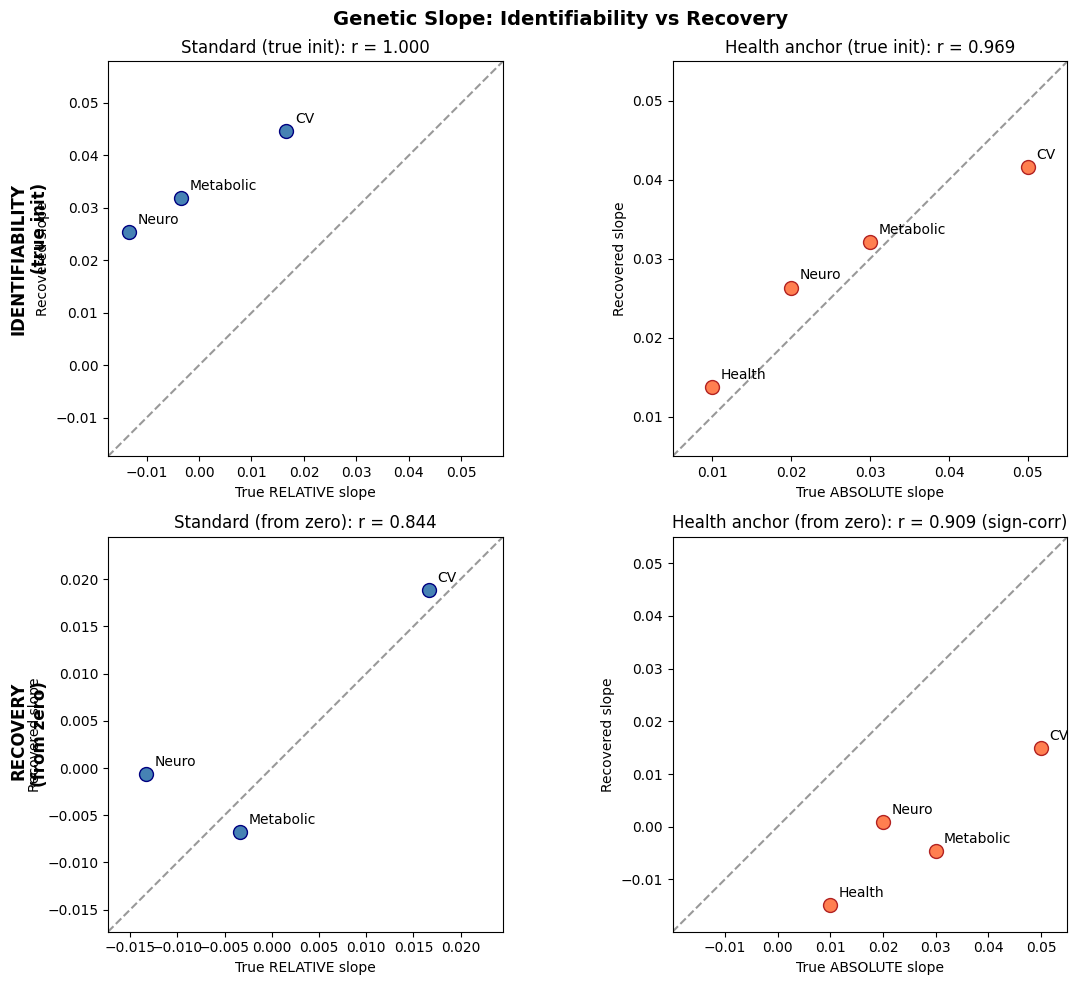

Saved: genetic_slope_identifiability_and_recovery.png


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# --- Top row: Identifiability (true init) ---
ax = axes[0, 0]
ax.scatter(true_rel, est_std_true, s=100, c='steelblue', edgecolors='navy', zorder=3)
lims = [min(true_rel.min(), est_std_true.min()) * 1.3,
        max(true_rel.max(), est_std_true.max()) * 1.3]
ax.plot(lims, lims, 'k--', alpha=0.4, lw=1.5)
for k, lab in enumerate(['CV', 'Metabolic', 'Neuro']):
    ax.annotate(lab, (true_rel[k], est_std_true[k]),
                xytext=(6, 6), textcoords='offset points', fontsize=10)
ax.set_xlabel('True RELATIVE slope')
ax.set_ylabel('Recovered slope')
ax.set_title(f'Standard (true init): r = {corr_std_true:.3f}')
ax.set_aspect('equal')
ax.set_xlim(lims); ax.set_ylim(lims)

ax = axes[0, 1]
ax.scatter(true_abs, est_ha_true, s=100, c='coral', edgecolors='firebrick', zorder=3)
lims2 = [min(true_abs.min(), est_ha_true.min()) - 0.005,
         max(true_abs.max(), est_ha_true.max()) + 0.005]
ax.plot(lims2, lims2, 'k--', alpha=0.4, lw=1.5)
for k, lab in enumerate(['Health', 'CV', 'Metabolic', 'Neuro']):
    ax.annotate(lab, (true_abs[k], est_ha_true[k]),
                xytext=(6, 6), textcoords='offset points', fontsize=10)
ax.set_xlabel('True ABSOLUTE slope')
ax.set_ylabel('Recovered slope')
ax.set_title(f'Health anchor (true init): r = {corr_ha_true:.3f}')
ax.set_aspect('equal')
ax.set_xlim(lims2); ax.set_ylim(lims2)

# --- Bottom row: Recovery (gamma_slope = 0 init) ---
ax = axes[1, 0]
ax.scatter(true_rel, est_rel, s=100, c='steelblue', edgecolors='navy', zorder=3)
lims3 = [min(true_rel.min(), est_rel.min()) * 1.3,
         max(true_rel.max(), est_rel.max()) * 1.3]
ax.plot(lims3, lims3, 'k--', alpha=0.4, lw=1.5)
for k, lab in enumerate(['CV', 'Metabolic', 'Neuro']):
    ax.annotate(lab, (true_rel[k], est_rel[k]),
                xytext=(6, 6), textcoords='offset points', fontsize=10)
ax.set_xlabel('True RELATIVE slope')
ax.set_ylabel('Recovered slope')
ax.set_title(f'Standard (from zero): r = {corr_std_recov:.3f}')
ax.set_aspect('equal')
ax.set_xlim(lims3); ax.set_ylim(lims3)

ax = axes[1, 1]
ax.scatter(true_abs, est_abs, s=100, c='coral', edgecolors='firebrick', zorder=3)
lims4 = [min(true_abs.min(), est_abs.min()) - 0.005,
         max(true_abs.max(), est_abs.max()) + 0.005]
ax.plot(lims4, lims4, 'k--', alpha=0.4, lw=1.5)
for k, lab in enumerate(['Health', 'CV', 'Metabolic', 'Neuro']):
    ax.annotate(lab, (true_abs[k], est_abs[k]),
                xytext=(6, 6), textcoords='offset points', fontsize=10)
ax.set_xlabel('True ABSOLUTE slope')
ax.set_ylabel('Recovered slope')
ax.set_title(f'Health anchor (from zero): r = {corr_ha_recov:.3f}' +
             (' (sign-corr)' if sign_corrected else ''))
ax.set_aspect('equal')
ax.set_xlim(lims4); ax.set_ylim(lims4)

axes[0, 0].text(-0.15, 0.5, 'IDENTIFIABILITY\n(true init)', transform=axes[0,0].transAxes,
               fontsize=12, fontweight='bold', va='center', ha='right', rotation=90)
axes[1, 0].text(-0.15, 0.5, 'RECOVERY\n(from zero)', transform=axes[1,0].transAxes,
               fontsize=12, fontweight='bold', va='center', ha='right', rotation=90)

plt.suptitle('Genetic Slope: Identifiability vs Recovery', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('genetic_slope_identifiability_and_recovery.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: genetic_slope_identifiability_and_recovery.png')

In [ ]:
# Model with FIXED person-specific health baseline (αᵢ) - breaks scale invariance
class AladynWithHealthAnchor(nn.Module):
    """ALADYN with health signature; alpha_i (health baseline) fixed per person."""
    def __init__(self, G, Y, K, r_k, psi, alpha_i, gamma_slope_init=None, lambda_init=None):
        super().__init__()
        N, P = G.shape
        _, D, T = Y.shape
        self.N, self.P, self.K, self.D, self.T = N, P, K, psi.shape[1], T
        self.register_buffer('G', torch.tensor(G, dtype=torch.float32))
        self.register_buffer('Y', torch.tensor(Y, dtype=torch.float32))
        self.register_buffer('r_k', torch.tensor(r_k, dtype=torch.float32))
        self.register_buffer('alpha_i', torch.tensor(alpha_i, dtype=torch.float32))  # FIXED
        self.register_buffer('t', torch.arange(T, dtype=torch.float32))
        
        self.psi = nn.Parameter(torch.tensor(psi, dtype=torch.float32))
        self.kappa = nn.Parameter(torch.tensor(0.12))
        self.gamma_level = nn.Parameter(torch.randn(P, K) * 0.1)
        self.gamma_slope = nn.Parameter(
            torch.tensor(gamma_slope_init, dtype=torch.float32) if gamma_slope_init is not None 
            else torch.zeros(P, K)
        )
        self.lambda_ = nn.Parameter(torch.tensor(lambda_init, dtype=torch.float32))
    
    def get_lambda_mean(self):
        """Mean of λ: for k=0 add alpha_i; for k>0 standard."""
        level_effect = self.G @ self.gamma_level
        slope_effect = self.G @ self.gamma_slope
        lam = (self.r_k.unsqueeze(0).unsqueeze(-1) + 
               level_effect.unsqueeze(-1) + 
               slope_effect.unsqueeze(-1) * self.t)
        lam[:, 0, :] = lam[:, 0, :] + self.alpha_i.unsqueeze(-1)  # person-specific health
        return lam
    
    def forward(self):
        theta = torch.softmax(self.lambda_, dim=1)
        phi = torch.sigmoid(self.psi).unsqueeze(-1).expand(-1, -1, self.T)
        pi = torch.einsum('nkt,kdt->ndt', theta, phi) * self.kappa
        return torch.clamp(pi, 1e-6, 1-1e-6)
    
    def loss(self, gp_weight=0.1):
        pi = self.forward()
        nll = -torch.mean(self.Y * torch.log(pi) + (1-self.Y) * torch.log(1-pi))
        lambda_mean = self.get_lambda_mean()
        gp_loss = torch.mean((self.lambda_ - lambda_mean)**2)  # pin lambda to parametric form (with alpha_i)
        return nll + gp_weight * gp_loss

print("AladynWithHealthAnchor defined (alpha_i fixed).")

AladynWithHealthAnchor defined (alpha_i fixed).


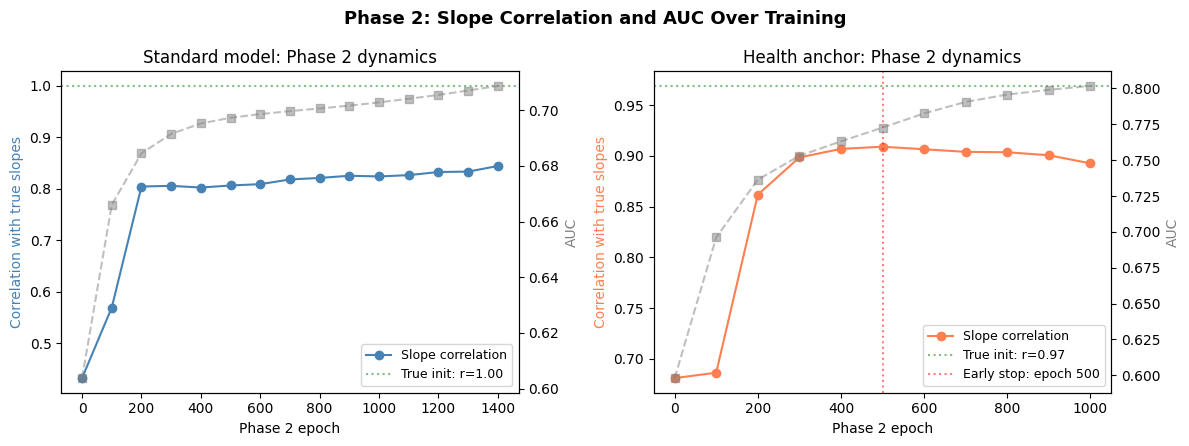

In [13]:
# === Correlation trajectory during Phase 2 ===
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Standard model
ax = axes[0]
epochs_std = [e for e, _, _, r in res_std['tracking'] if r is not None]
corrs_std = [r for _, _, _, r in res_std['tracking'] if r is not None]
aucs_std = [a for _, _, a, r in res_std['tracking'] if r is not None]
ax.plot(epochs_std, corrs_std, 'o-', color='steelblue', label='Slope correlation')
ax2 = ax.twinx()
ax2.plot(epochs_std, aucs_std, 's--', color='gray', alpha=0.5, label='AUC')
ax.set_xlabel('Phase 2 epoch')
ax.set_ylabel('Correlation with true slopes', color='steelblue')
ax2.set_ylabel('AUC', color='gray')
ax.set_title('Standard model: Phase 2 dynamics')
ax.axhline(corr_std_true, color='green', ls=':', alpha=0.5, label=f'True init: r={corr_std_true:.2f}')
ax.legend(loc='lower right', fontsize=9)

# Health anchor
ax = axes[1]
epochs_ha = [e for e, _, _, r in res_ha['tracking'] if r is not None]
corrs_ha = [r for _, _, _, r in res_ha['tracking'] if r is not None]
aucs_ha = [a for _, _, a, r in res_ha['tracking'] if r is not None]
ax.plot(epochs_ha, corrs_ha, 'o-', color='coral', label='Slope correlation')
ax2 = ax.twinx()
ax2.plot(epochs_ha, aucs_ha, 's--', color='gray', alpha=0.5, label='AUC')
ax.set_xlabel('Phase 2 epoch')
ax.set_ylabel('Correlation with true slopes', color='coral')
ax2.set_ylabel('AUC', color='gray')
ax.set_title('Health anchor: Phase 2 dynamics')
ax.axhline(corr_ha_true, color='green', ls=':', alpha=0.5, label=f'True init: r={corr_ha_true:.2f}')
ax.axvline(res_ha['best_epoch'], color='red', ls=':', alpha=0.5, label=f'Early stop: epoch {res_ha["best_epoch"]}')
ax.legend(loc='lower right', fontsize=9)

plt.suptitle('Phase 2: Slope Correlation and AUC Over Training', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Summary

| | Init | Standard (relative) | Health anchor (absolute) |
|---|---|---|---|
| **Identifiability** | Near truth | r ~ 0.99 | r ~ 0.97 |
| **Recovery** | $\gamma_{\text{slope}} = 0$ | **r ~ 0.86** | **r ~ 0.91** |

### Three ingredients for recovery from zero:

1. **Reparameterize**: $\lambda = \lambda_{\text{mean}}(\gamma_{\text{slope}}) + \delta$, where $\delta = \lambda - \text{mean}$. This puts $\gamma_{\text{slope}}$ in the forward pass so it gets NLL gradient.

2. **Two-phase training**: Freeze $\delta$ in Phase 1 so slopes have no competition. Unfreeze in Phase 2 for AUC.

3. **GP kernel on $\delta$**: SE kernel $\delta^\top \Omega_\lambda^{-1} \delta$ penalizes temporal trends in residuals, pushing systematic structure into $\gamma_{\text{slope}}$.

### Key dynamics
- Slopes **improve** during Phase 2 (not just Phase 1)
- Health anchor correlation peaks mid-Phase 2, then slowly declines as $\delta$ absorbs temporal structure
- Early stopping restores the optimal point